In [56]:
from qiskit import *
simulator = Aer.get_backend('qasm_simulator')

# Algorithme de Deutsch-Josza

C'est le premier algorithme présentatn un avantage d'un ordinateur quantique sur son équivalent classique. Il vise à résoudre un problème bien précis ce qui le rend inutile outre sa fonction de démonstration.

## Le problème

On a une fonction $f : \{0,1\}^n \longrightarrow \{0,1\}$, qui prend $n$ bits en entrées et en sort un en sortie. De plus, cette fonction est soit constante, soit équilibrée, donc soit toute les entrées donne la même sortie, soit la moitié donne 0 et l'autre 1. Le défi et de déterminer si l'on a une fonction de ce type quelle est sont comportement.

## Les solutions

### Classique

De manière classique, pour être sûr du type de la fonction, nous devons tester la moitié des entrées plus une. Nous devons donc appliqué notre fonction pour un nombre d'entrée $N=2^n$, $N/2+1 = 2^{n-1}+1$ fois. On voit donc que cela grossit exponentiellement au nombre de bits considéré.

In [57]:
def cst_class(bits:str):
    """
    bits de la forme '0110001'

    Retourne toujours la même valeur
    """
    valeur = 0
    return valeur

In [58]:
def equ_class(bits:str):
    """
    bits de la forme '0110001'

    Retourne 0 pour la moitié des bits, 1 pour l'autre moitié
    """
    if bits[0] == '0':
        return 0
    else:
        return 1

In [59]:
def solve_class(fun, n_bits):
    """
    fun : fonction à tester
    n_bits : nombre de bits de l'entrée

    Affiche si la fonction est constante ou équilibrée
    """
    prec_res = -1
    for i in range(int(2**n_bits / 2 + 1)):
        bit = bin(i)[2:].zfill(n_bits)
        if prec_res == -1:
            prec_res = fun(bit)
        else:
            if prec_res != fun(bit):
                print("La fonction est équilibrée")
                return
    print("La fonction est constante")

In [60]:
print("Fonction constante".center(50, "-"))
solve_class(cst_class, 7)
print("Fonction équilibrée".center(50, "-"))
solve_class(equ_class, 7)

----------------Fonction constante----------------
La fonction est constante
---------------Fonction équilibrée----------------
La fonction est équilibrée


### Quantique

De manière quantique, nous pouvons résoudre ce problème de en n'appelant qu'une seule fois la fonction. Pour ce faire nous préparons notre système, exécutons la fonction (que l'on va nommer oracle car elle transforme transforme _output_ dans le résultat de la fonction sur _entry_), appliquons une dernière opération et on mesure.

In [61]:
N = 3 # Nombre de bits de l'entrée de la fonction
entry = QuantumRegister(N, 'entry')
output = QuantumRegister(1, 'output')
mes = ClassicalRegister(N, 'mes')

In [62]:
cst_quantum = QuantumCircuit(entry, output)
cst_quantum = cst_quantum.to_gate(label="Oracle")

In [63]:
equ_quantum = QuantumCircuit(entry, output)
for i in range(N):
    equ_quantum.cx(entry[i], output[0])
equ_quantum = equ_quantum.to_gate(label="Oracle")

In [64]:
def deutsch_jozsa(oracle):
    """
    oracle : fonction à tester

    Retourne le circuit quantique de l'algorithme de Deutsch-Jozsa
    """
    dj = QuantumCircuit(entry, output, mes)
    dj.x(output)
    dj.barrier()
    dj.h(entry)
    dj.h(output)
    dj.append(oracle, [i for i in range(N + 1)])
    dj.h(entry)
    dj.measure(entry, mes)
    return dj

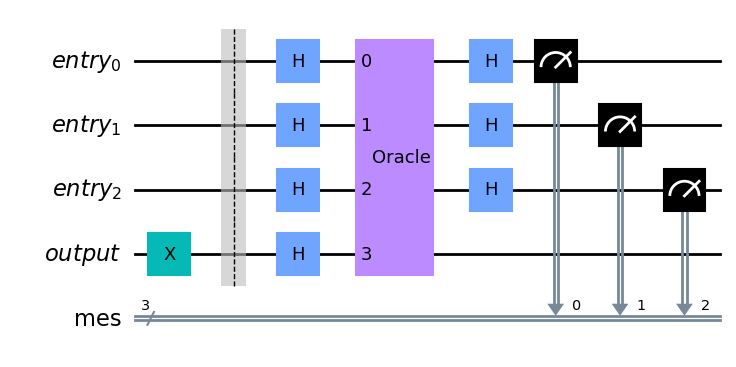

In [65]:
# Affichage du circuit
deutsch_jozsa(cst_quantum).draw(output='mpl')

In [66]:
print("Fonction constante".center(50, "-"))
dj_cst = deutsch_jozsa(cst_quantum)
results = execute(dj_cst, simulator, shots=1000).result()
counts = results.get_counts()
print(counts)

print("Fonction équilibrée".center(50, "-"))
dj_equ = deutsch_jozsa(equ_quantum)
results = execute(dj_equ, simulator, shots=1000).result()
counts = results.get_counts()
print(counts)

----------------Fonction constante----------------
{'000': 1000}
---------------Fonction équilibrée----------------
{'111': 1000}


Nous voyons donc que l'algorithme donne 0 pour une fonction constante et 1 pour une équilibrée en un seul appel !

>**Démonstration pour $n=1$**
>
>On commence donc après la barrière avec les qubits dans l'état $\ket{0}\ket{1}$, qui
>deviennent $\frac{1}{2}(\ket{0}+\ket{1})(\ket{0}-\ket{1})$ après l'application de la
>première porte d'Hadamard sur chacun des qubits.
>Ensuite, on applique l'oracle, qui va modifier les qubits d'entrée en fonction de la
>fonction $f$ comme suit :
>$$
>    \ket{x}\ket{y} \rightarrow \ket{x}\ket{f(x) \oplus y}
>$$
>En l'appliquant sur le circuit, on obtient :
>$$
>    \frac{1}{2}(\ket{0} (\ket{f(0) \oplus 0}-\ket{f(0) \oplus 1}) + \ket{1}(\ket{f(1) \oplus 0}-\ket{f(1) \oplus 1}))
>$$
>En séparant les cas, on observe que
>$$
>    \begin{cases}
>        f(0) = 0 \Rightarrow f(0) \oplus 0 = 0 \text{ et } f(0) \oplus 1 = 1 \Rightarrow (\ket{f(0) \oplus 0}-\ket{f(0) \oplus 1}) = >(\ket{0}-\ket{1})\\
>        f(0) = 1 \Rightarrow f(0) \oplus 0 = 1 \text{ et } f(0) \oplus 1 = 0 \Rightarrow (\ket{f(0) \oplus 0}-\ket{f(0) \oplus 1}) = >(\ket{1}-\ket{0}) = -(\ket{0}-\ket{1})
>    \end{cases}
>$$
>et similairement pour $f(1)$.\\
>On peut donc réécrire $\ket{f(0) \oplus 0}-\ket{f(0) \oplus 1}$ comme $(-1)^{f(0)}(\ket{0}-\ket{1})$
>et $\ket{f(1) \oplus 0}-\ket{f(1) \oplus 1}$ comme $(-1)^{f(1)}(\ket{0}-\ket{1})$,
>ce qui nous donne :
>$$
>    \frac{1}{2}((-1)^{f(0)} \ket{0} (\ket{0}-\ket{1}) + (-1)^{f(1)} \ket{1}(\ket{0}-\ket{1}))
>$$
>Mettons ensuite $(-1)^{f(0)}$ en évidence, et comme $(-1)^n$ alterne, on peut écrire
>$(-1)^{f(1) - f(0)} = (-1)^{f(0) \oplus f(1)}$, ainsi que $(\ket{0}-\ket{1})$ mis en évidence :
>$$
>    (-1)^{f(0)} \frac{1}{2} (\ket{0} + (-1)^{f(0) \oplus f(1)} \ket{1})(\ket{0}-\ket{1})
>$$
>L'opérateur $\oplus$, qui est l'addition modulo 2, est équivalent à l'opérateur XOR, comme évoqué dans la section~\ref>{ch:un-ordinateur-classique}.
>Or, si $f(0) = f(1)$, l'oracle est constant, ce qui est équivalent à dire que $f(0) \oplus f(1) = 0$.
>Essayons donc d'extraire cette information du circuit.\\
>Pour la suite on ne se soucie plus du qubit de sortie, car on le voit dans l'équation,
>ce n'est pas lui qui va nous donner l'information.
>De plus, la phase globale $(-1)^{f(0)}$ n'est pas observable, car elle ne change pas
>la probabilité de mesure, on peut donc l'ignorer également.
>Nous ne soucions donc plus que des qubits d'entrée, et on peut réécrire l'équation
>comme suit :
>$$
>    \frac{1}{\sqrt{2}} (\ket{0} + (-1)^{f(0) \oplus f(1)} \ket{1})
>$$
>qui devient ensuite par la porte d'Hadamard :
>$$
>    \frac{1}{2} (\ket{0} + \ket{1} + (-1)^{f(0) \oplus f(1)} \ket{0} - (-1)^{f(0) \oplus f(1)} \ket{1}) = \frac{1}{2} ((1 + (-1)^{f>(0) \oplus f(1)}) \ket{0} + (1 - (-1)^{f(0) \oplus f(1)}) \ket{1})
>$$
>On constate alors que si $f(0) \oplus f(1) = 0$, alors la probabilité de mesure de
>$\ket{0}$ est de 1, et si $f(0) \oplus f(1) = 1$, alors la probabilité de mesure de
>$\ket{1}$ est de 1, ainsi, en mesurant le qubit d'entrée, on peut déterminer si
>l'oracle est constant ou équilibré.

On peut faire une démonstration similaire pour $n$ qubits.